In [ ]:
#Mounting on co-lab
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.insert(0,'/content/drive/My Drive/Interpretable_DNN') # change folder name

Mounted at /content/drive


In [ ]:
#Import of Libaries

import os
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import math
import itertools
import pickle
from numpy.ma.core import argmax

#Data Preprocessing
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.cluster import KMeans


#Model Building and Explanations
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, backend, Model, callbacks
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, classification_report
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


#custom functions
from functions.data_proc import *
from functions.experiment_setup import *
from functions.generate_inputs import *


In [ ]:


#Directories
MY_WORKSPACE_DIR = "/content/drive/My Drive/Interpretable_DNN/BPIC17_v2"

#Dataset
file_name = os.path.join(MY_WORKSPACE_DIR,'BPIC_2017_OUTCOME.csv')
log_name = 'bpic_2017'




In [ ]:

log_df = pd.read_csv(file_name)
log_df = log_df.reset_index(drop=True)


In [ ]:
log_df.head()

CASEID              ACTIVITY  ACTIVITY_INDEX RESOURCE  \
0  Application_1018407971  A_Create Application               1  User_48   
1  Application_1018407971             A_Concept               2  User_48   
2  Application_1018407971            A_Accepted               3  User_48   
3  Application_1018407971        O_Create Offer               4  User_48   
4  Application_1018407971             O_Created               5  User_48   

               START_TIMESTAMP           COMPLETE_TIMESTAMP  TIME_ELAPSED  \
0  2016-05-26 22:40:20.0790000  2016-05-26 22:40:20.0790000             0   
1  2016-05-26 22:40:20.0790000  2016-05-26 22:40:20.1200000             0   
2  2016-05-26 22:40:20.1200000  2016-05-26 22:49:48.0130000             0   
3  2016-05-26 22:49:48.0130000  2016-05-26 23:06:10.0350000             0   
4  2016-05-26 23:06:10.0350000  2016-05-26 23:06:11.4870000             1   

   TASK_DURATION  CREDIT_SCORE    APP_TYPE  AMT_REQ  TERMS     OUTCOME  
0              0             0  New credit  25000.0    101  O_Accepted  
1              0             0  New credit  25000.0    101  O_Accepted  
2              0             0  New credit  25000.0    101  O_Accepted  
3              1           892  New credit  25000.0    101  O_Accepted  
4              0             0  New credit  25000.0    101  O_Accepted

#### How early should be the prediction

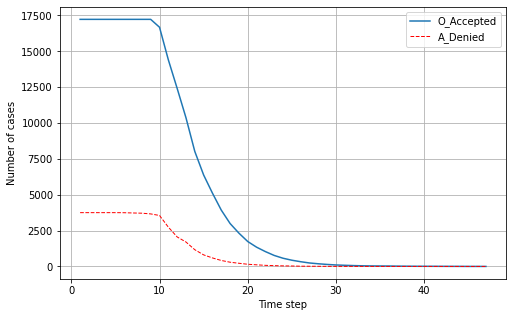

In [ ]:
# How predictable is the outcome as we move along the trace

df_t = log_df.groupby(['ACTIVITY_INDEX','OUTCOME'])['CASEID'].size().reset_index()
df_t = df_t.pivot(index='ACTIVITY_INDEX',columns = 'OUTCOME', values = 'CASEID').reset_index()
df_t = df_t.fillna(0)
x = df_t['ACTIVITY_INDEX']
y_0 = df_t['O_Accepted']
y_1 = df_t['A_Denied']


plt.figure(num = 3, figsize=(8, 5))
plt.plot(x, y_0 ,label = 'O_Accepted')
plt.plot(x, y_1, 
         color='red',   
         linewidth=1.0,  
         linestyle='--',
         label = 'A_Denied' 
        )
plt.xlabel('Time step')
plt.ylabel('Number of cases')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

In [ ]:
color_p = sn.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)


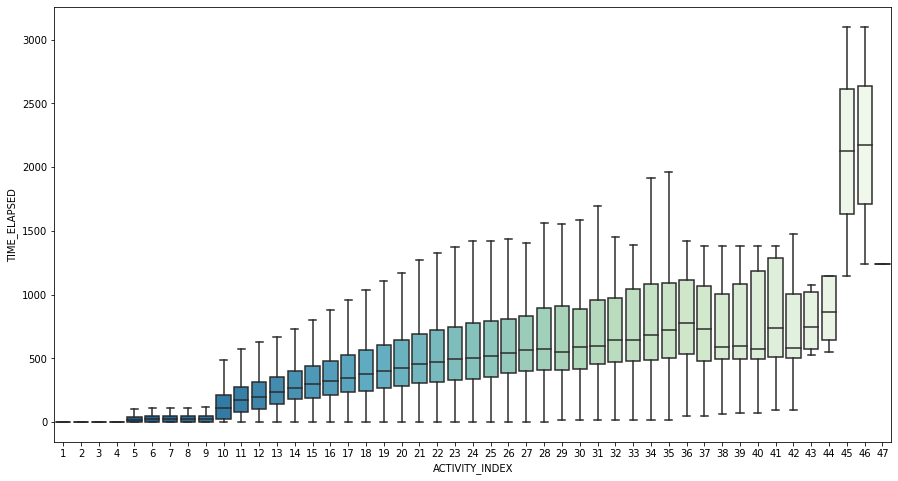

In [ ]:
# Distribution of the time spent on each case by the timestep

#bx = log_df.boxplot(column = 'TIME_ELAPSED', by = 'ACTIVITY_INDEX' )

plt.figure(figsize=(15,8))
ax = sn.boxplot(x='ACTIVITY_INDEX', y='TIME_ELAPSED', palette='GnBu_r', data=log_df, showfliers = False)

In [ ]:
#distribution of activity counts by the timestep
df_t = log_df.groupby(['CASEID','ACTIVITY'])['ACTIVITY_INDEX'].min().reset_index()
df_t = df_t.groupby(['ACTIVITY_INDEX','ACTIVITY'])['CASEID'].size().reset_index()
df_t = df_t.pivot(index='ACTIVITY_INDEX',columns = 'ACTIVITY', values = 'CASEID')
df_t = df_t.fillna(0)


In [ ]:
#activity order in average
df_act = log_df.groupby('ACTIVITY')['ACTIVITY_INDEX'].min().reset_index()
df_act = df_act.sort_values(by=['ACTIVITY_INDEX'])

In [ ]:
col = df_act['ACTIVITY'].to_list()

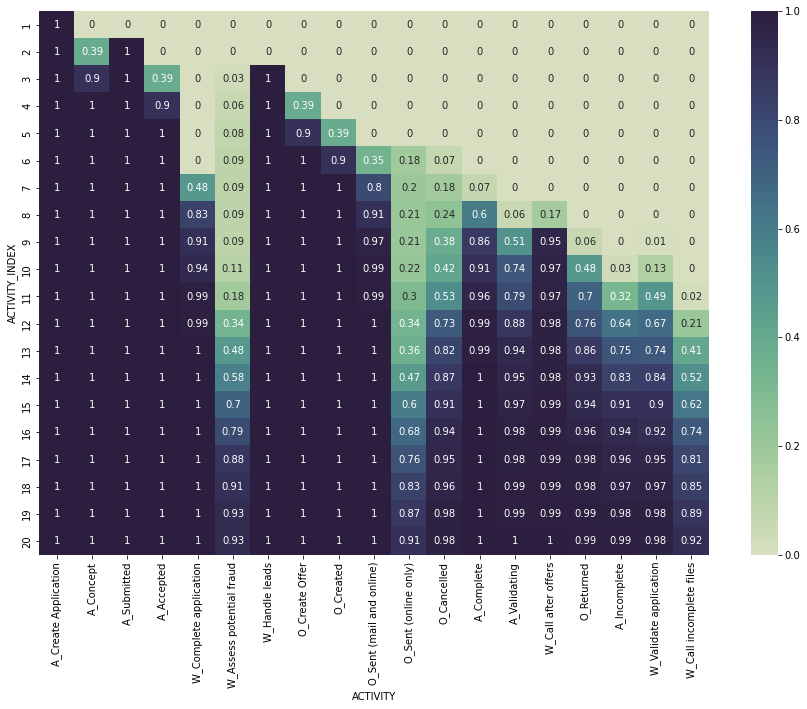

In [ ]:
df_a = df_t[col]
df_a = round(df_a.cumsum()/df_a.sum(),2)
df_a = df_a.iloc[:20]
plt.figure(figsize=(15,10))
ax = sn.heatmap(df_a, cmap=color_p ,annot=True, fmt="g")

In [ ]:
df_b = df_t[col]
df_b = df_b.sum().reset_index()
df_b.columns = ['ACTIVITY','CASES']

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]), <a list of 19 Text major ticklabel objects>)

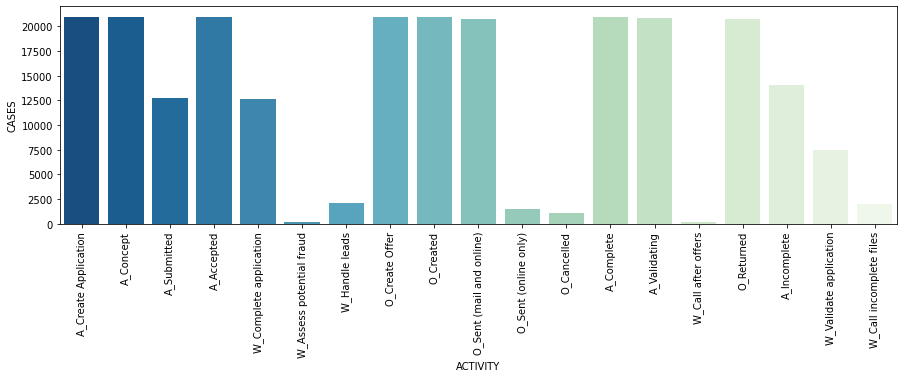

In [ ]:
plt.figure(figsize=(15,4))
ax = sn.barplot(data=df_b, x='ACTIVITY', y='CASES',palette='GnBu_r')
plt.xticks(rotation=90)


<ipython-input-46-4f3f96d71658>:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(cor, dtype=np.bool))


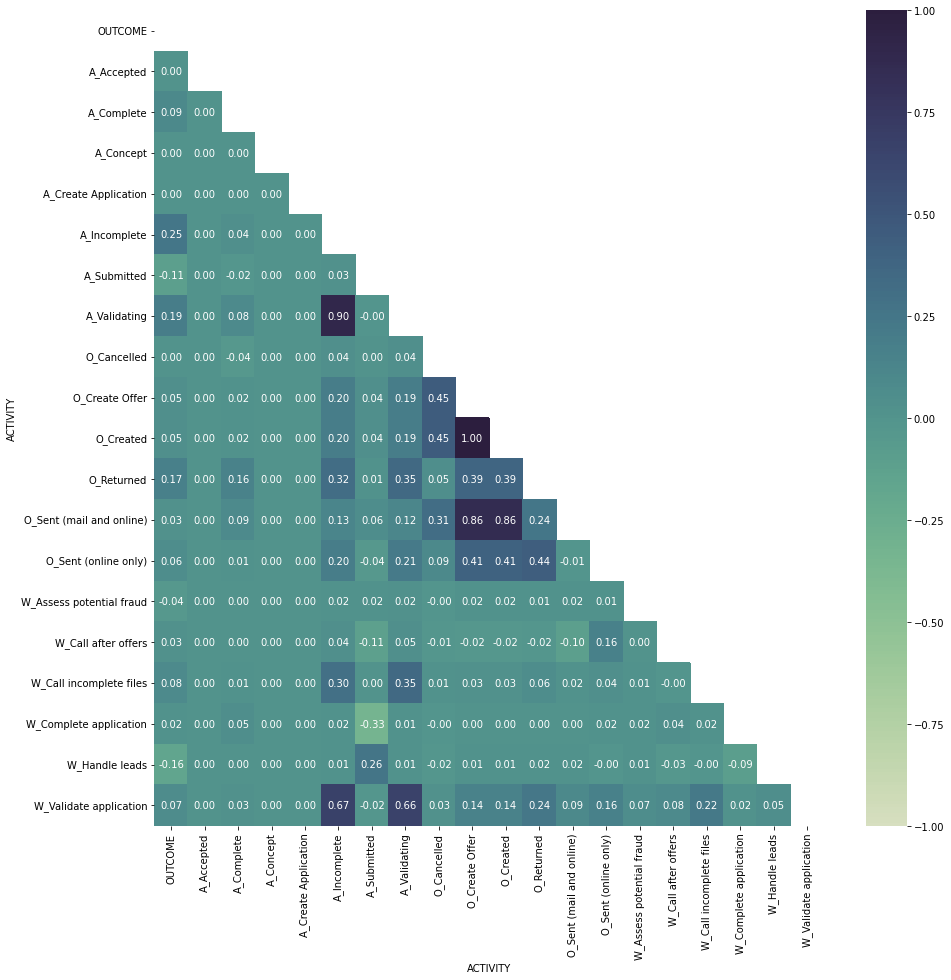

In [ ]:
df_t1 = log_df.groupby(['CASEID','ACTIVITY','OUTCOME'])['ACTIVITY_INDEX'].size().reset_index()
df_t1 = df_t1.pivot(index=['CASEID','OUTCOME'],columns = 'ACTIVITY', values = 'ACTIVITY_INDEX').reset_index() 

df_t1['OUTCOME'] = df_t1['OUTCOME'].map({'O_Accepted': 1,'A_Denied':0})
df_t1 = df_t1.fillna(0)

cor = df_t1.corr()
cor = cor.fillna(0)
mask = np.triu(np.ones_like(cor, dtype=np.bool))

plt.figure(figsize=(15,15))
ax = sn.heatmap(cor, cmap=color_p, mask = mask, annot=True, fmt='.2f',vmin=-1, vmax=1)
